## Classifying Palmer Penguins

#### Importing packages and reading in our data 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN
3,PAL0910,146,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,"Adult, 1 Egg Stage",N82A2,Yes,11/16/09,39.0,18.7,185.0,3650.0,MALE,9.22033,-26.03442,NaN
4,PAL0708,24,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N85A2,No,11/28/07,50.6,19.4,193.0,3800.0,MALE,9.28153,-24.97134,NaN


#### Data Acknowledgment 
Data used in this blog post were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

#### Building the Model
The aim of this post was to identify a subset of the available features that could be used to train a classification model. To accomplish this task, we must first prepare the data accordingly, which we do using the following function prepare_data. This function drops identifying information from the study which will not be useful in predictive modeling, as well as separating the target vector from the rest of the dataset.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)

With our data appropriately cleaned and partitioned, we can now begin to formulate a model. The model of choice here is a random forest, which is an ensemble method made up of multiple decision trees. These individual trees are created from random independent samples or subsets of data, whose decisions are averaged in making predictions. To effectively choose features that accurately predict penguin species, we can build multiple models using different, independent combinations of columns. We can evaluate each of these models and score them to quantify their performance and choose the combination which obtains the highest score. The following block of code selects a unique subset of columns, both qualitative and quantitative, trains a model using the partitioned training dataset, and tests its accuracy on the testing dataset.

In [6]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

all_qual_cols = ["Island", "Sex", "Clutch Completion"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)']

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols
    print("Columns: " + str(cols))
    rfc = RandomForestClassifier()
    X_train_curr = X_train[cols]
    rfc.fit(X_train_curr, y_train)
    preds = rfc.predict(X_test[cols])
    print("Model Score: " + str(accuracy_score(y_test, preds)))
    
    

Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.9852941176470589
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.9852941176470589
Columns: ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Model Score: 0.8676470588235294
Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 0.9852941176470589
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 1.0
Columns: ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Sex_FEMALE', 'Sex_MALE']
Model Score: 0.7941176470588235
Columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
Model Score: 0.9705882352941176
Columns: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']
Model Score: 0.970588235

While many of the models achieved high accuracy scores, only one achieved 100% testing accuracy. The features used in the creation of this model were Culmen Length, Flipper Length, and Sex. To get a better understanding of why or how these features led to the best model, we can look at some summary statistics at the species level. 

In [18]:
train.groupby(["Species", "Sex"])[["Culmen Length (mm)", "Flipper Length (mm)"]].mean()

Culmen Length (mm)  \
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE           37.100000   
                                          MALE             40.458182   
Chinstrap penguin (Pygoscelis antarctica) FEMALE           46.424138   
                                          MALE             51.185185   
Gentoo penguin (Pygoscelis papua)         .                44.500000   
                                          FEMALE           45.600000   
                                          MALE             49.592593   

                                                  Flipper Length (mm)  
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE           187.719298  
                                          MALE             192.690909  
Chinstrap penguin (Pygoscelis antarctica) FEMALE           191.551724  
                                          MALE             199.666667  
Gentoo penguin (Pygoscelis papua)         .                217.000000  
                                          FEMALE           212.928571  
                                          MALE             221.462963

Looking at the average culmen and flipper lengths across species and sexes, we notice that Gentoo penguins have a notably high flipper length and Adelie penguins have shorter culmens compared to the other species. To better understand this distinction we can visualize these metrics using a scatter plot, faceted by sex.

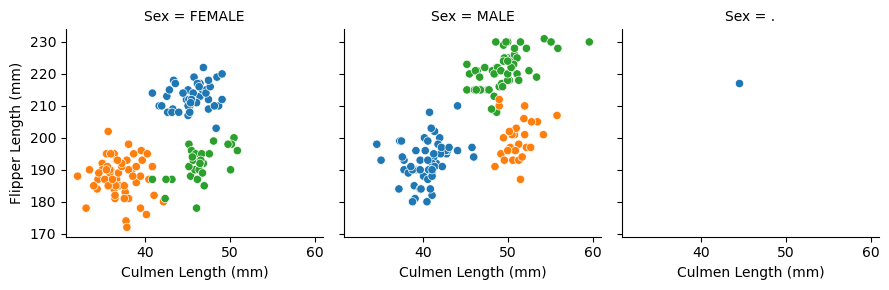

In [30]:
g = sns.FacetGrid(data = train, col = 'Sex')
g.map(sns.scatterplot, "Culmen Length (mm)", "Flipper Length (mm)", 'Species')

Interesting point to note: one of the penguins did not have a sex recorded, and this penguin is plotted on its own graph where sex = "." located at the far right. With the data plotted, it becomes easy to see why this choice of features led to such a high accuracy. The data initially appears to be seperable, with only a few instances of near overlap. 

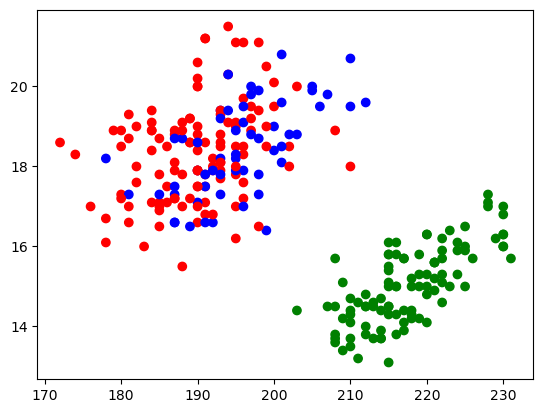

In [101]:
colors = {"Adelie Penguin (Pygoscelis adeliae)" : "Red", "Chinstrap penguin (Pygoscelis antarctica)" : "Blue", "Gentoo penguin (Pygoscelis papua)" : "Green"}
fig = plt.scatter(train["Flipper Length (mm)"], train["Culmen Depth (mm)"], c=train['Species'].map(colors))

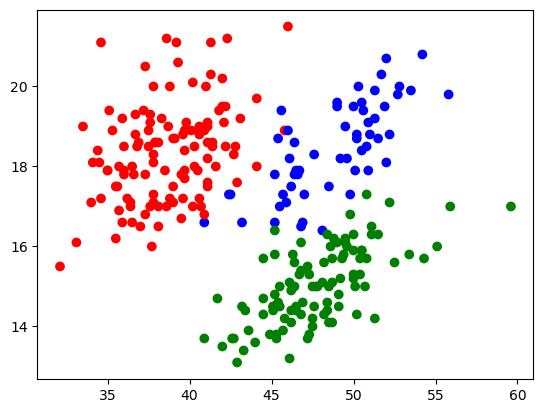

In [102]:
fig = plt.scatter(train["Culmen Length (mm)"], train["Culmen Depth (mm)"], c=train['Species'].map(colors))

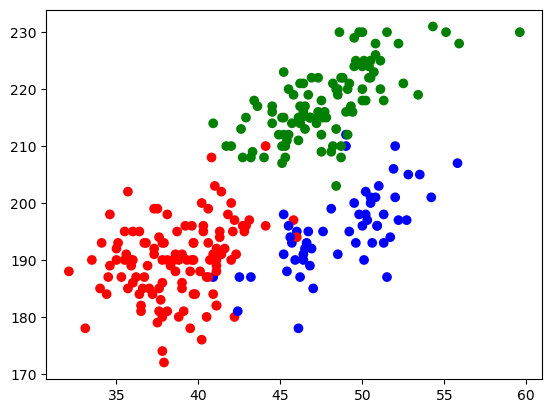

In [123]:
fig = plt.scatter(train["Culmen Length (mm)"], train["Flipper Length (mm)"], c=train['Species'].map(colors))

In [115]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

1.0


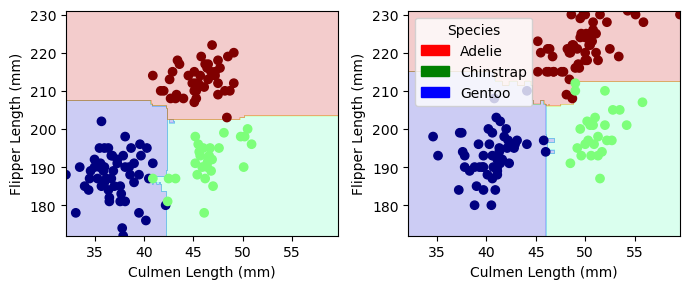

In [125]:
rfc = RandomForestClassifier()
cols = ["Culmen Length (mm)", "Flipper Length (mm)", "Sex_FEMALE", "Sex_MALE"]
rfc.fit(X_train[cols], y_train)
print(rfc.score(X_train[cols], y_train))

plot_regions(rfc, X_train[cols], y_train)